In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# !pip install deepxde

# from deepxde.backend.set_default_backend import set_default_backend
# set_default_backend("tensorflow")

import deepxde as dde
from tf_siren import SinusodialRepresentationDense


Using backend: tensorflow



In [20]:
brench = 100

def activation1(x):
  return tf.math.sin(x)

def activation2(x):
  return tf.math.sin(20 * x)

kernel_init = 'glorot_uniform'

inputs1 = tf.keras.layers.Input(shape = (1))
inputs2 = tf.keras.layers.Input(shape = (1))

inp = tf.concat([inputs1,inputs2],1)
# x = tf.keras.layers.Dense(brench ,activation= activation2, kernel_initializer=kernel_init)(inp)
# x = tf.keras.layers.Dense(brench ,activation= activation1, kernel_initializer=kernel_init)(x)
# x = tf.keras.layers.Dense(brench ,activation= activation1, kernel_initializer=kernel_init)(x)

x = SinusodialRepresentationDense(100, activation='sine', w0=20.0)(inp)
x = SinusodialRepresentationDense(100, activation='sine', w0=1.0)(x)
x = SinusodialRepresentationDense(100, activation='sine', w0=1.0)(x)
x = SinusodialRepresentationDense(100, activation='tanh', w0=1.0)(x)
x = SinusodialRepresentationDense(100, activation='tanh', w0=1.0)(x)
outputs = tf.keras.layers.Dense(1 ,activation='linear')(x) 
NN = tf.keras.Model([inputs1,inputs2], outputs)


In [5]:
# NN.save('./reaction-diffusion.h5')

In [6]:
# NN = tf.keras.models.load_model('./reaction-diffusion.h5')

In [7]:
T = 0.4
L = 0.3
N = 50

a = (np.geomspace(1,1001,N) - 1) * (T/1000)
b = np.linspace(0,L,N)
t = []
x = []
for j in a:
  for i in b:
    t.append(j)
    x.append(i)

train_t = np.array(t).reshape(-1,1)
train_x = np.array(x).reshape(-1,1)


a = np.linspace(0,T,10*N)
b = np.linspace(0,L,10*N)

t = []
x = []
for j in a:
  for i in b:
    t.append(j)
    x.append(i)

test_t = np.array(t).reshape(-1,1)
test_x = np.array(x).reshape(-1,1)

In [8]:
# train_t = tf.constant(train_t, dtype=tf.float32)
# train_x = tf.constant(train_x, dtype=tf.float32)
# train_t = tf.data.Dataset.from_tensor_slices(train_t)
# train_x = tf.data.Dataset.from_tensor_slices(train_x)

# train_t = train_t.batch(30)
# train_x = train_x.batch(30)

In [9]:
def pde_system(t,x, net):
    t = tf.constant(t, dtype = tf.float32) 
    x = tf.constant(x, dtype = tf.float32) 
    
    D = 1
    k = 400

    with tf.GradientTape() as tape:
      tape.watch(x)
      with tf.GradientTape() as tape2:
        tape2.watch(x)
        with tf.GradientTape() as tape3:
          tape3.watch(t)

          u = net([t,x])
          u_t = tape3.gradient(u, t)
        u_x = tape2.gradient(u, x)
      u_xx = tape.gradient(u_x, x)
    
    pde_loss = u_t - D * u_xx + k * u
    # pde_loss = tf.math.log(1+tf.square(pde_loss))
    pde_loss = tf.square(pde_loss)
    pde_loss = tf.reduce_mean(pde_loss)

    BC1_t = tf.constant(np.linspace(0.01 * T, T,100).reshape(-1,1), dtype = tf.float32)
    BC1_x = tf.constant(np.linspace(0,0,100).reshape(-1,1), dtype = tf.float32)

    BC1 = net([BC1_t,BC1_x]) - 1
    # BC1_loss = tf.math.log(1+tf.square (BC1))
    BC1_loss = tf.square (BC1)
    BC1_loss = tf.reduce_mean(BC1_loss)

    BC2_t = tf.constant(np.linspace(0,T,100).reshape(-1,1), dtype = tf.float32)
    BC2_x = tf.constant(np.linspace(L,L,100).reshape(-1,1), dtype = tf.float32)

    with tf.GradientTape() as tape:
      tape.watch(BC2_x)

      BC2 = net([BC2_t,BC2_x])

      BC_u_x = tape.gradient(BC2, BC2_x)

    # BC2_loss = tf.math.log(1+tf.square(BC_u_x))
    BC2_loss = tf.square(BC_u_x)
    BC2_loss = tf.reduce_mean(BC2_loss)

    IC_t = tf.constant(np.linspace(0,0,100).reshape(-1,1), dtype = tf.float32)
    IC_x = tf.constant(np.linspace(0,L,100).reshape(-1,1), dtype = tf.float32)
    
    IC = net([IC_t, IC_x])
    IC_loss = tf.square(IC)
    IC_loss = tf.reduce_mean(IC_loss)
    return pde_loss, BC1_loss, BC2_loss, IC_loss

In [10]:
# train_loss_record = []
# lr = 1e-3

# optm = tf.keras.optimizers.Adam(lr=lr)
# for itr in range(5000):
#   with tf.GradientTape() as tape:
#     pde_loss,BC1_loss, BC2_loss, IC_loss = pde_system(train_t,train_x, NN)
#     train_loss = 1e-4 * pde_loss + BC1_loss + BC2_loss  + IC_loss
    
#     grad_w = tape.gradient(train_loss, NN.trainable_variables)
#     optm.apply_gradients(zip(grad_w, NN.trainable_variables))

#   train_loss_record.append(train_loss)

#   if itr % 100 == 0:
#       print(f"{itr} : {pde_loss.numpy():.3e},  {BC1_loss.numpy():.3e},  {BC2_loss.numpy():.3e},  {IC_loss.numpy():.3e}")
#       lr = lr * 0.94
#       optm.learning_rate = lr


In [21]:
train_loss_record = []

weight1 = 1e-4
weight2 = 1.
weight3 = 1.
weight4 = 1.

lr = 1e-4

optm = tf.keras.optimizers.Adam(learning_rate=lr)
for itr in range(10000):
  with tf.GradientTape() as tape2:
    if itr % 100 == 0:

      with tf.GradientTape(persistent=True) as tape:
        tape.watch(NN.trainable_variables)

        pde_loss,BC1_loss, BC2_loss, IC_loss = pde_system(train_t,train_x, NN)

      grad1 = tape.gradient(pde_loss, NN.trainable_variables)
      grad2 = tape.gradient(BC1_loss, NN.trainable_variables)
      grad3 = tape.gradient(BC2_loss, NN.trainable_variables)
      grad4 = tape.gradient(IC_loss, NN.trainable_variables)

      del tape

      abc = tf.constant([[0.]])
      for i in grad1:
        asd = tf.math.square(i)
        asd = tf.reshape(asd,(-1,1))
        abc = tf.concat([abc,asd],0)
      a1 = tf.sqrt(tf.reduce_mean(abc)).numpy()

      abc = tf.constant([[0.]])

      for i in grad2:
        asd = tf.math.square(i)
        asd = tf.reshape(asd,(-1,1))
        abc = tf.concat([abc,asd],0)
      a2 = tf.sqrt(tf.reduce_mean(abc)).numpy()
      a_all = a1 + a2

      abc = tf.constant([[0.]])
      for i in grad3:
        if i is None:
          continue
        asd = tf.math.square(i)
        asd = tf.reshape(asd,(-1,1))
        abc = tf.concat([abc,asd],0)
      a3 = tf.sqrt(tf.reduce_mean(abc)).numpy()
      a_all = a_all + a3

      abc = tf.constant([[0.]])
      for i in grad4:
        asd = tf.math.square(i)
        asd = tf.reshape(asd,(-1,1))
        abc = tf.concat([abc,asd],0)
      a4 = tf.sqrt(tf.reduce_mean(abc)).numpy()
      a_all = a_all + a4

      if itr == 0:
        # weight1 = 1 - a1/a_all
        # weight2 = 1 - a2/a_all
        # weight3 = 1 - a3/a_all
        # weight4 = 1 - a4/a_all
        pass
      else:
        weight1 = weight1 - 0.2 * (weight1 - (1 - a1/a_all))
        weight2 = weight2 - 0.2 * (weight2 - (1 - a2/a_all))
        weight3 = weight3 - 0.2 * (weight3 - (1 - a3/a_all))
        weight4 =  weight4 - 0.2 * (weight4 - (1 - a4/a_all))

    else:
        pde_loss,BC1_loss, BC2_loss, IC_loss = pde_system(train_t,train_x, NN)
        
    # train_loss = weight1 * pde_loss + weight2 * BC1_loss + weight3 * BC2_loss  + weight4 * IC_loss
    
    train_loss = 0.001 * pde_loss +  BC1_loss +  BC2_loss  +  IC_loss

    grad_w = tape2.gradient(train_loss, NN.trainable_variables)
    optm.apply_gradients(zip(grad_w, NN.trainable_variables))

  train_loss_record.append(pde_loss + BC1_loss + BC2_loss  + IC_loss)

  if itr % 100 == 0:
      print(f"{itr} : {pde_loss.numpy():.3e},  {BC1_loss.numpy():.3e},  {BC2_loss.numpy():.3e},  {IC_loss.numpy():.3e}")
      print(weight1, weight2, weight3, weight4 )
      print((1 - a1/a_all) , (1 - a2/a_all) , (1 - a3/a_all) , (1 - a4/a_all) )


0 : 1.835e+04,  2.570e+00,  3.375e-01,  1.305e-01
0.0001 1.0 1.0 1.0
6.723403930664062e-05 0.9999664262468286 0.9999731272055215 0.9999932306373012
100 : 4.224e+01,  9.447e-01,  1.471e-02,  1.153e-05
0.0003425226974487305 0.9997641340363771 0.9999738080165116 0.9999995487469733
0.0013126134872436523 0.9988206701818854 0.9998690400825581 0.9999977437348662
200 : 6.000e+01,  8.616e-01,  5.137e-03,  7.480e-06
0.0004876769676208496 0.9996152550727129 0.9999616689118557 0.9999994138248576
0.0010682940483093262 0.9990197392180562 0.9999131124932319 0.999998874136395
300 : 7.112e+01,  8.041e-01,  8.781e-04,  1.844e-05
0.0005973630821228028 0.9994953955048695 0.9999594143329014 0.9999990446579359
0.0010361075401306152 0.999015957233496 0.9999503960170841 0.9999975679902491
400 : 8.369e+01,  7.424e-01,  2.575e-04,  8.439e-05
0.0006808085183715821 0.9993976536106318 0.9999642362735205 0.9999982867920458
0.0010145902633666992 0.999006686033681 0.9999835240359971 0.9999952553284857
500 : 9.634e+01

KeyboardInterrupt: 

1095 : 1.003e+02,  1.859e-01,  1.182e-03, 6.317e-03
425.32605 0.3377015 0.032011345 0.027937468
0.0009340643882751465 0.9992067589773796 0.9999248072272167 0.9999343765230151
0.0001


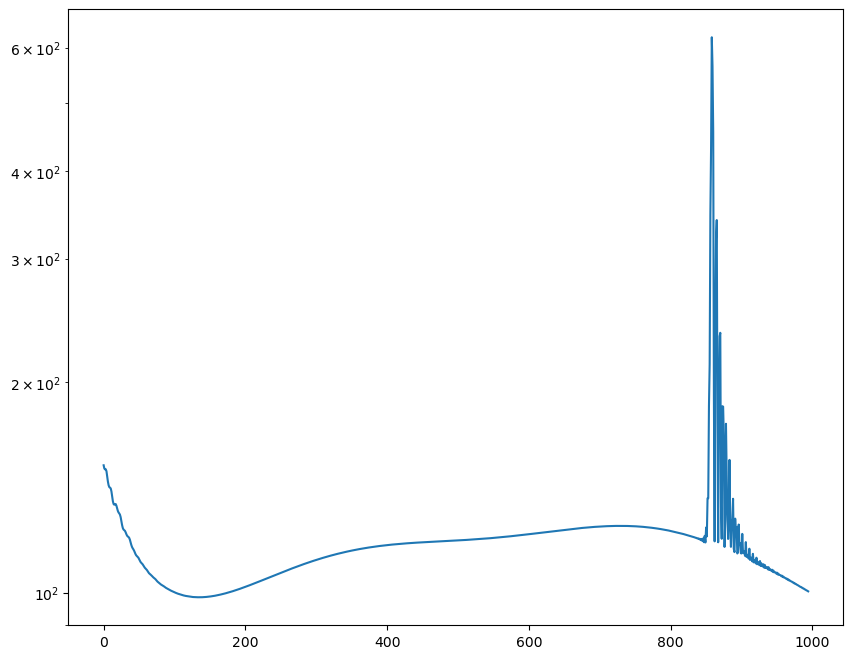

In [15]:
print(f"{itr} : {pde_loss.numpy():.3e},  {BC1_loss.numpy():.3e},  {BC2_loss.numpy():.3e}, {IC_loss.numpy():.3e}")
print(a1,a2,a3,a4)
print((1 - a1/a_all) , (1 - a2/a_all) , (1 - a3/a_all) , (1 - a4/a_all) )
print(lr)

plt.figure(figsize = (10,8))
plt.yscale('log')
plt.plot(train_loss_record[100:])
plt.show()

In [16]:
pred = NN.predict([test_t,test_x],batch_size=len(test_t))

a = pred.reshape(10*N,10*N)

b1 = []
b2 = []
b3 = []
b4 = []
for i in a:
  b1.append(i[1])
  b2.append(i[int(3*N)])
  b3.append(i[int(8*N)])
  b4.append(i[10*N-1])

1/1 [==============================] - 0s 254ms/step


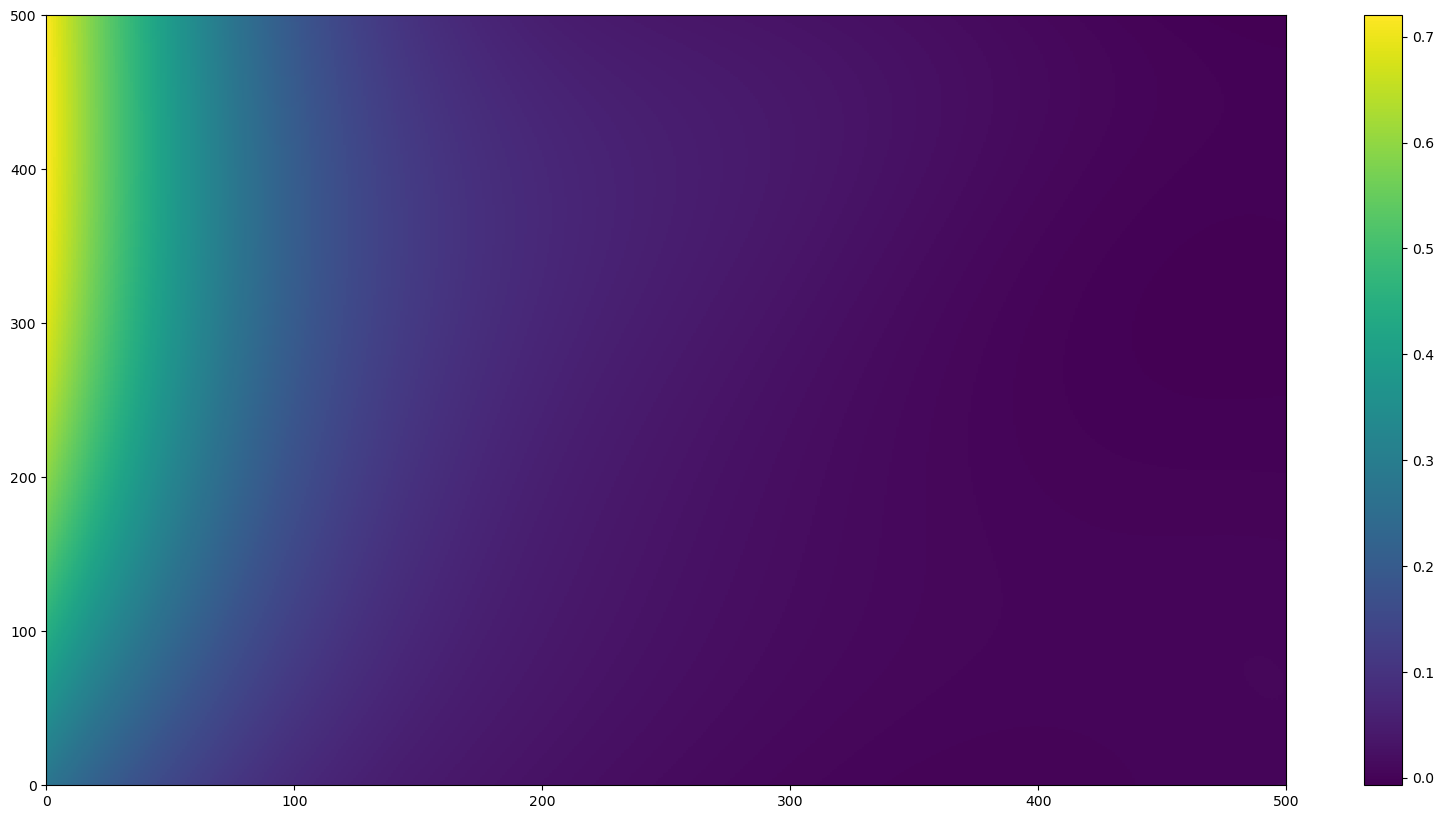

In [17]:
plt.figure(figsize=(20,10))
plt.pcolor(a)
plt.colorbar()

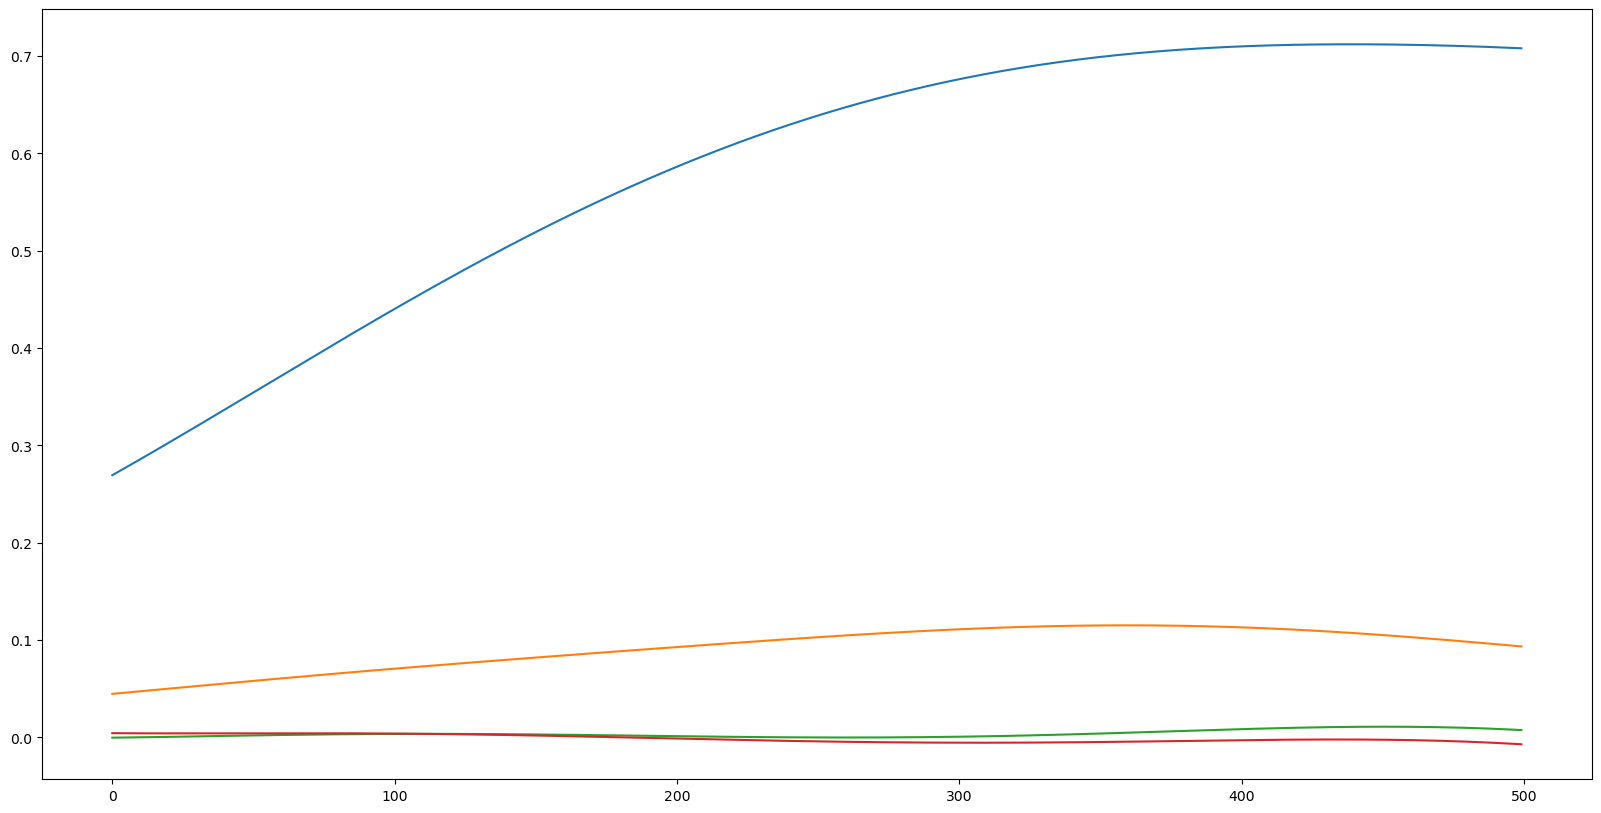

In [18]:
plt.figure(figsize=(20,10))
plt.plot(b1)
plt.plot(b2)
plt.plot(b3)
plt.plot(b4)

In [87]:
def loss_val():
    pde_loss,BC1_loss, BC2_loss, IC_loss = pde_system(train_t,train_x, NN)
    train_loss = 0.5 * pde_loss + BC1_loss + BC2_loss  + IC_loss
    return train_loss


In [88]:
result = dde.optimizers.tfp_optimizer.lbfgs_minimize(NN.trainable_variables, loss_val)

pde_system(train_t,train_x, NN)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0022962193>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.006506333>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00022555207>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.001326082>)

In [89]:
pred = NN.predict([test_t,test_x],batch_size=len(test_t))

a = pred.reshape(10*N,10*N)

b1 = []
b2 = []
b3 = []
b4 = []
for i in a:
  b1.append(i[1])
  b2.append(i[int(5*N)])
  b3.append(i[int(9*N)])
  b4.append(i[10*N-1])

1/1 [==============================] - 0s 170ms/step


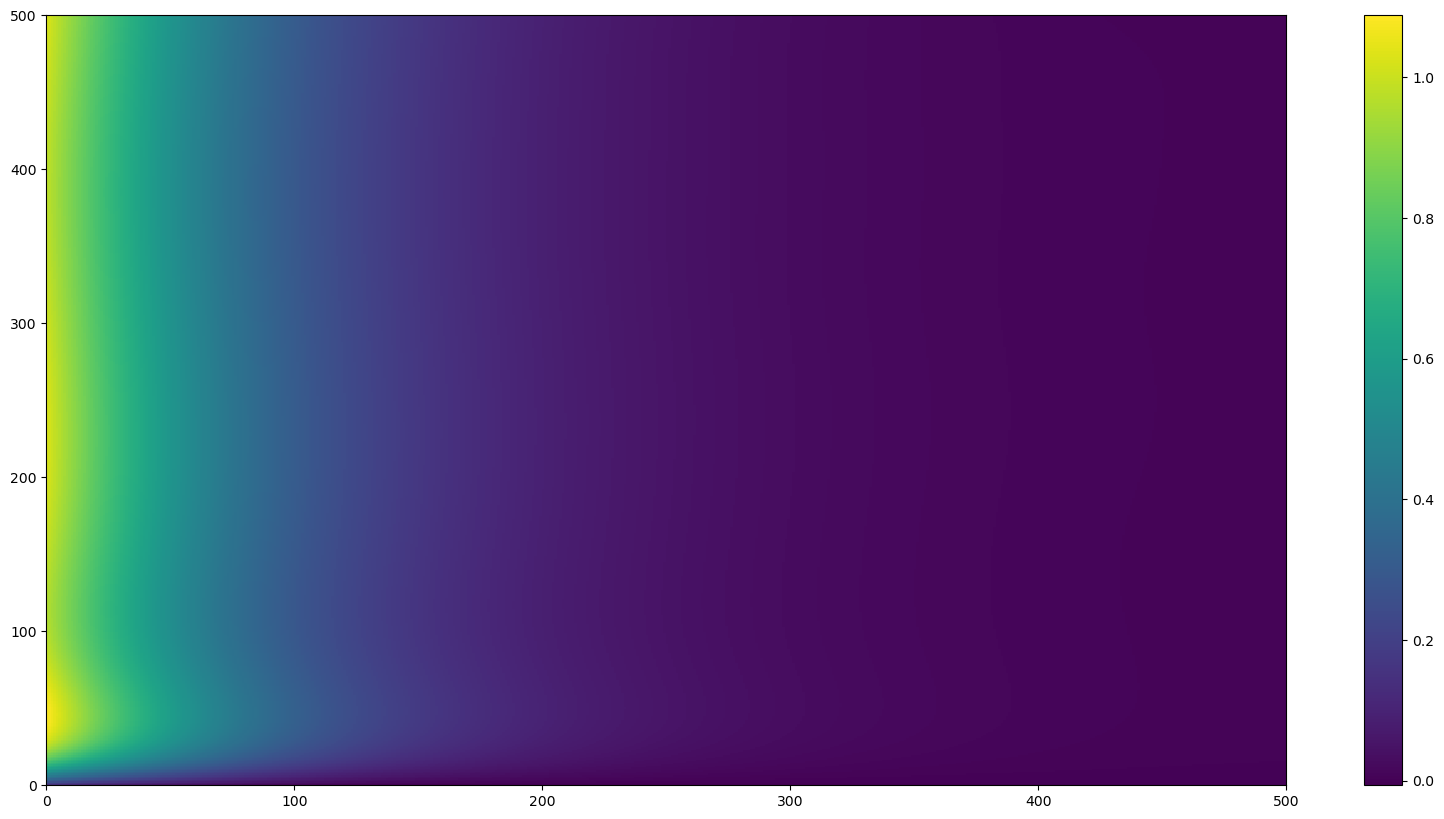

In [90]:
plt.figure(figsize=(20,10))
plt.pcolor(a)
plt.colorbar()

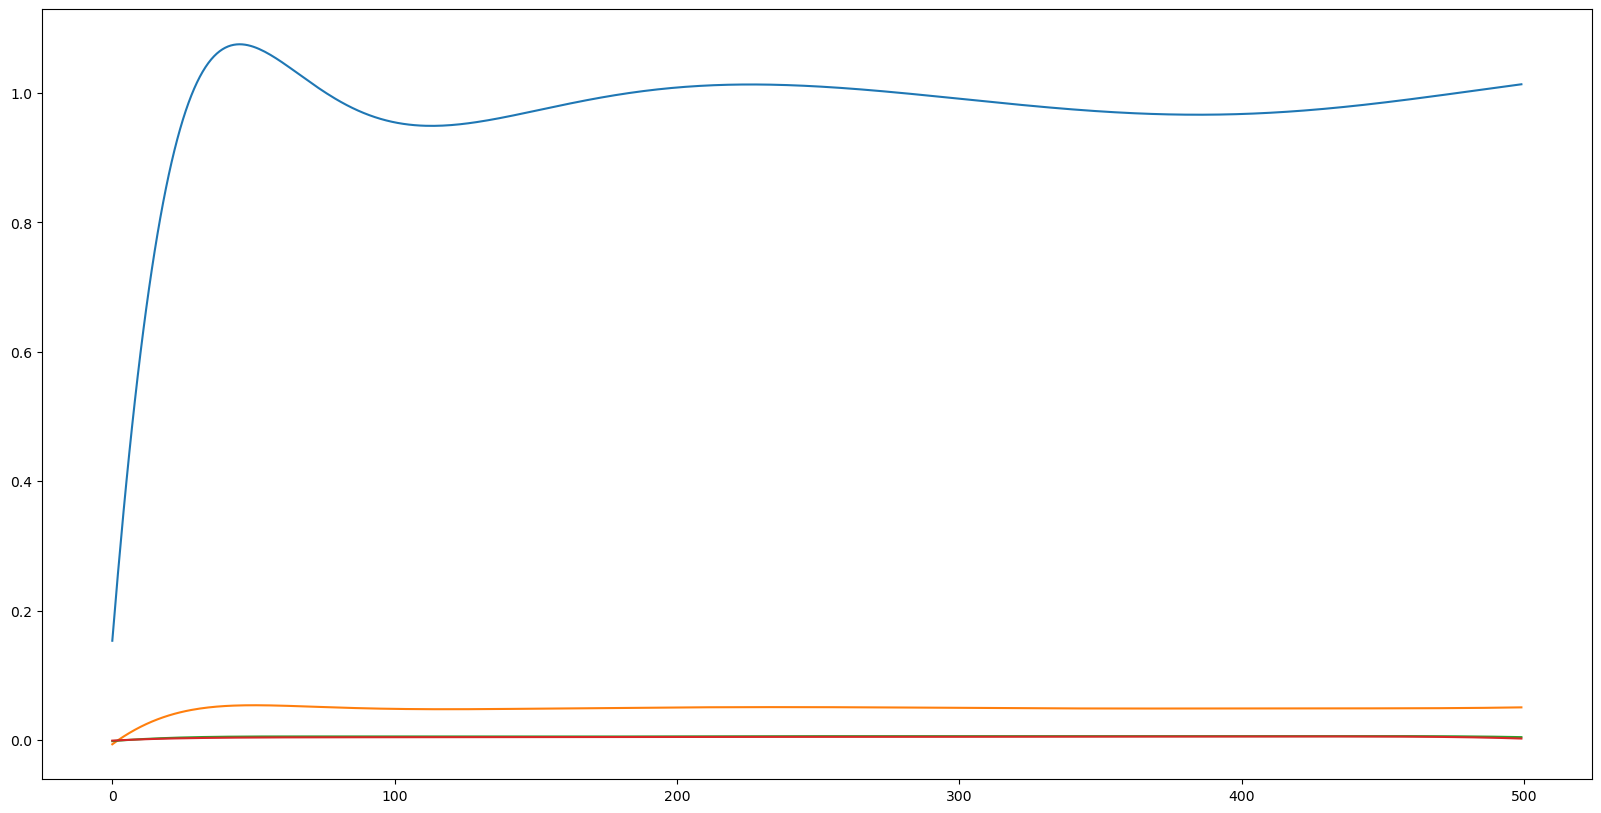

In [91]:
plt.figure(figsize=(20,10))
plt.plot(b1)
plt.plot(b2)
plt.plot(b3)
plt.plot(b4)